Atividade 1 - Implementando uma rede neural recorrente em Python (Colab)

(Exercício 2 dos slides da aula) - Implementar uma solução em
Python, usando redes neurais recorrentes, capaz de estimar um ano de
temperatura do solo a partir dos dados informados para os anos anteriores. Comparar o desempenho de uma RNN simples com uma estrutura do tipo LSTM. Explicar em detalhes as principais funções/recursos empregados, bem como a configuração dos dados preparada para ser executada, como tamanho da sequencia, dimensão de entrada, dimensão de saída dos dados e dimensão do estado oculto das redes.

In [2]:
# -----------------------------------------------------------------------------
# 0) Dependências
# -----------------------------------------------------------------------------
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# -----------------------------------------------------------------------------
# 1) Configurações (ajuste se necessário)
# -----------------------------------------------------------------------------
SEQUENCE_LENGTH = 5 # usar 5 anos anteriores -> prediz o próximo ano
TEST_RATIO = 0.15
VAL_RATIO = 0.15
RANDOM_STATE = 42
EPOCHS = 200
BATCH_SIZE = 8
MODEL_SAVE_PATH = '/content/soil_temp_rnn_simple.h5'


YEAR_COL = None # ex: 'year', 'ano', 'data'
TEMP_COL = None # ex: 'temp', 'temperature', 'soil_temp'

In [5]:
# -----------------------------------------------------------------------------
# 2) Montar Google Drive (Colab) e definir caminho base
# -----------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')
print('Google Drive montado com sucesso!')


# Caminho base informado pelo usuário
base_dir = '/content/drive/MyDrive/Mestrado_PPGI/2AS2_IA_GENERATIVA/Aula 03/bases_csv'
print('Diretório base definido como:', base_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado com sucesso!
Diretório base definido como: /content/drive/MyDrive/Mestrado_PPGI/2AS2_IA_GENERATIVA/Aula 03/bases_csv


In [6]:
# -----------------------------------------------------------------------------
# 3) Carregar todos os CSVs do diretório
# -----------------------------------------------------------------------------
# Verifica se o diretório existe
if not os.path.isdir(base_dir):
    raise FileNotFoundError(f'O diretório {base_dir} não existe.')

# Lista todos os arquivos CSV
csv_files = glob.glob(os.path.join(base_dir, '*.csv'))
print(f'Encontrados {len(csv_files)} arquivos CSV no diretório {base_dir}')

if len(csv_files) == 0:
    raise FileNotFoundError(f'Nenhum CSV encontrado em {base_dir}. Verifique o caminho.')

# Lê todos os CSVs e concatena em um único DataFrame
dfs = []
for file in csv_files:
    df_temp = pd.read_csv(file)
    df_temp['_source_file'] = os.path.basename(file)
    dfs.append(df_temp)

# Concatena tudo
data = pd.concat(dfs, ignore_index=True)

print(f'DataFrame final montado com sucesso! Total de registros: {len(data)}')
print('Visualização das primeiras linhas:')
display(data.head())

Encontrados 15 arquivos CSV no diretório /content/drive/MyDrive/Mestrado_PPGI/2AS2_IA_GENERATIVA/Aula 03/bases_csv
DataFrame final montado com sucesso! Total de registros: 2011647
Visualização das primeiras linhas:


,nws_id,physicalelement,datetime(GMT),sitename,wfo,latitude,longitude,soiltemp(F),depth(in),afos_id,extremum,_source_file,Unnamed: 11
0,ABR,TB,9/30/2009 13:00,Aberdeen Muni Arpt (WFO & ASOS),ABR,45.455833,-98.412778,48.0,2,KABRRR3ABR,Z,2009_soil_temp.csv,NaN
1,ALNM4,TB,9/30/2009 15:00,Albion 1NW,DTX,42.261944,-84.774167,53.0,2,KGRRRR2GRR,Z,2009_soil_temp.csv,NaN
2,ATKM5,TB,9/28/2009 12:00,Aitkin 2E,DLH,46.533889,-93.703056,51.0,2,KDLHRR3DLH,Z,2009_soil_temp.csv,NaN
3,BATM4,TB,9/30/2009 15:00,Bath 2ENE - MSU Ag Mesonet,GRR,42.827778,-84.386111,53.0,2,KGRRRR2GRR,Z,2009_soil_temp.csv,NaN
4,BELM4,TB,9/30/2009 15:00,Belding 3WNW - MSU Ag Mesonet,GRR,43.110000,-85.310000,54.0,2,KGRRRR2GRR,Z,2009_soil_temp.csv,NaN


In [7]:
# -----------------------------------------------------------------------------
# 4) Preparar colunas de data e temperatura
# -----------------------------------------------------------------------------
print("Colunas encontradas no dataset:")
print(list(data.columns))

# Define as colunas relevantes
YEAR_COL = 'datetime(GMT)'
TEMP_COL = 'soiltemp(F)'

# Converte a data e extrai o ano
data[YEAR_COL] = pd.to_datetime(data[YEAR_COL], errors='coerce')
data = data.dropna(subset=[YEAR_COL, TEMP_COL]).copy()
data['year'] = data[YEAR_COL].dt.year

# Converte a temperatura para numérico
data['temp_F'] = pd.to_numeric(data[TEMP_COL], errors='coerce')

# (Opcional) converte Fahrenheit → Celsius
data['temp_C'] = (data['temp_F'] - 32) * 5/9

# Agrupa por ano (média anual da temperatura do solo)
annual = (
    data.groupby('year')['temp_C']
    .mean()
    .reset_index()
    .sort_values('year')
)

print(f"Período disponível: {annual['year'].min()} até {annual['year'].max()}")
print("Primeiras linhas da base anual:")
display(annual.head())

Colunas encontradas no dataset:
['nws_id', 'physicalelement', 'datetime(GMT)', 'sitename', 'wfo', 'latitude', 'longitude', 'soiltemp(F)', 'depth(in)', 'afos_id', 'extremum', '_source_file', 'Unnamed: 11']
Período disponível: 2009 até 2023
Primeiras linhas da base anual:


,year,temp_C
0,2009,5.657196
1,2010,9.739401
2,2011,9.118551
3,2012,10.174109
4,2013,8.415860


In [8]:
# -----------------------------------------------------------------------------
# 5) Criar sequências para previsão de temperatura
# -----------------------------------------------------------------------------
SEQUENCE_LENGTH = 5  # usa 5 anos anteriores para prever o próximo

def create_sequences(values, seq_length):
    X, y = [], []
    for i in range(len(values) - seq_length):
        X.append(values[i:i + seq_length])
        y.append(values[i + seq_length])
    return np.array(X), np.array(y)

values = annual['temp_C'].values.astype('float32')
years = annual['year'].values

X_all, y_all = create_sequences(values, SEQUENCE_LENGTH)
print(f'Total de sequências geradas: {len(X_all)}')

Total de sequências geradas: 10


In [9]:
# -----------------------------------------------------------------------------
# 6) Divisão temporal em treino, validação e teste
# -----------------------------------------------------------------------------
TEST_RATIO = 0.15
VAL_RATIO = 0.15

n = len(X_all)
n_test = int(np.ceil(TEST_RATIO * n))
n_val = int(np.ceil(VAL_RATIO * n))
n_train = n - n_val - n_test

X_train = X_all[:n_train]
X_val = X_all[n_train:n_train + n_val]
X_test = X_all[n_train + n_val:]

y_train = y_all[:n_train]
y_val = y_all[n_train:n_train + n_val]
y_test = y_all[n_train + n_val:]

print(f'Treino: {len(X_train)}, Validação: {len(X_val)}, Teste: {len(X_test)}')

Treino: 6, Validação: 2, Teste: 2


In [10]:
# -----------------------------------------------------------------------------
# 7) Escalonar dados
# -----------------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(y_train.reshape(-1, 1))

X_train_scaled = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).reshape(-1)
y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).reshape(-1)
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

In [11]:
# -----------------------------------------------------------------------------
# 8) Criar e compilar modelo RNN simples
# -----------------------------------------------------------------------------
model = Sequential([
    SimpleRNN(32, activation='tanh', input_shape=(SEQUENCE_LENGTH, 1)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,633 (6.38 KB)

 Trainable params: 1,633 (6.38 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# -----------------------------------------------------------------------------
# 9) Treinar o modelo
# -----------------------------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=200,
    batch_size=8,
    callbacks=[es],
    verbose=2
)

Epoch 1/200
1/1 - 4s - 4s/step - loss: 1.6375 - mae: 0.9823 - val_loss: 0.7168 - val_mae: 0.7613
Epoch 2/200
1/1 - 0s - 73ms/step - loss: 1.1884 - mae: 0.8676 - val_loss: 0.6766 - val_mae: 0.7510
Epoch 3/200
1/1 - 0s - 65ms/step - loss: 1.6015 - mae: 0.9220 - val_loss: 0.6257 - val_mae: 0.7336
Epoch 4/200
1/1 - 0s - 65ms/step - loss: 0.9761 - mae: 0.7691 - val_loss: 0.5739 - val_mae: 0.7136
Epoch 5/200
1/1 - 0s - 66ms/step - loss: 1.2186 - mae: 0.9398 - val_loss: 0.5314 - val_mae: 0.6963
Epoch 6/200
1/1 - 0s - 67ms/step - loss: 1.0570 - mae: 0.8703 - val_loss: 0.4902 - val_mae: 0.6774
Epoch 7/200
1/1 - 0s - 67ms/step - loss: 0.6083 - mae: 0.6311 - val_loss: 0.4553 - val_mae: 0.6596
Epoch 8/200
1/1 - 0s - 64ms/step - loss: 0.5649 - mae: 0.4991 - val_loss: 0.4261 - val_mae: 0.6442
Epoch 9/200
1/1 - 0s - 65ms/step - loss: 0.6814 - mae: 0.7152 - val_loss: 0.3966 - val_mae: 0.6259
Epoch 10/200
1/1 - 0s - 67ms/step - loss: 0.7628 - mae: 0.6267 - val_loss: 0.3754 - val_mae: 0.6117
Epoch 11/20

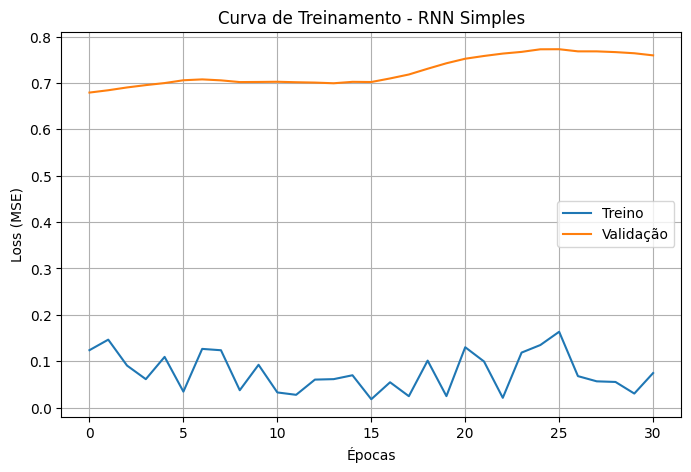

In [39]:
# -----------------------------------------------------------------------------
# 10) Visualizar curva de perda
# -----------------------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.title('Curva de Treinamento - RNN Simples')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
RMSE (teste): 1.0861
MAE  (teste): 0.8983


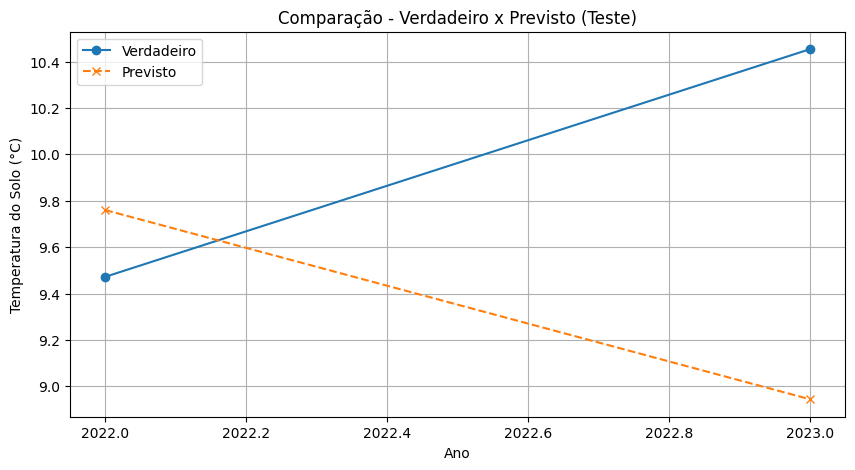

In [40]:
# -----------------------------------------------------------------------------
# 11) Avaliar o modelo no conjunto de teste
# -----------------------------------------------------------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

pred_test_scaled = model.predict(X_test_scaled).reshape(-1, 1)
pred_test = scaler.inverse_transform(pred_test_scaled).reshape(-1)

rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)

print(f"RMSE (teste): {rmse:.4f}")
print(f"MAE  (teste): {mae:.4f}")

# Plot das previsões vs reais
years_test = years[SEQUENCE_LENGTH + n_train + n_val : SEQUENCE_LENGTH + n_train + n_val + len(y_test)]

plt.figure(figsize=(10,5))
plt.plot(years_test, y_test, 'o-', label='Verdadeiro')
plt.plot(years_test, pred_test, 'x--', label='Previsto')
plt.title('Comparação - Verdadeiro x Previsto (Teste)')
plt.xlabel('Ano')
plt.ylabel('Temperatura do Solo (°C)')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predição da temperatura média do solo para 2024: 9.90 °C
Predição da temperatura média do solo para 2025: 9.29 °C


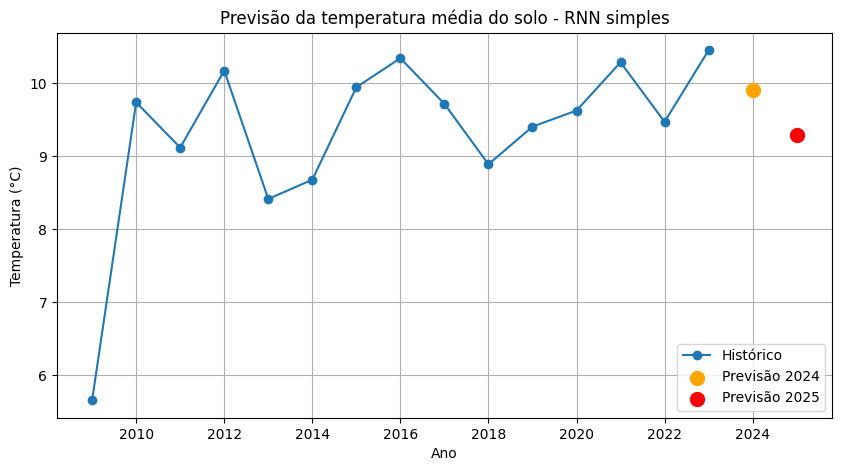

In [33]:
# -----------------------------------------------------------------------------
# 12) Predição para os anos de 2024 e 2025
# -----------------------------------------------------------------------------
# Seleciona a última sequência de anos conhecida
last_seq = values[-SEQUENCE_LENGTH:]
last_seq_scaled = scaler.transform(last_seq.reshape(-1, 1)).reshape(1, SEQUENCE_LENGTH, 1)

# Previsão para 2024
pred_2024_scaled = model.predict(last_seq_scaled)
pred_2024 = scaler.inverse_transform(pred_2024_scaled.reshape(-1, 1)).reshape(-1)[0]

# Adiciona a previsão de 2024 à sequência e prevê 2025
next_seq = np.append(last_seq[1:], pred_2024)  # remove o primeiro e adiciona o novo
next_seq_scaled = scaler.transform(next_seq.reshape(-1, 1)).reshape(1, SEQUENCE_LENGTH, 1)

pred_2025_scaled = model.predict(next_seq_scaled)
pred_2025 = scaler.inverse_transform(pred_2025_scaled.reshape(-1, 1)).reshape(-1)[0]

# Exibe resultados
print(f"Predição da temperatura média do solo para 2024: {pred_2024:.2f} °C")
print(f"Predição da temperatura média do solo para 2025: {pred_2025:.2f} °C")

# Gráfico incluindo previsões
plt.figure(figsize=(10, 5))
plt.plot(annual['year'], annual['temp_C'], marker='o', label='Histórico')
plt.scatter(2024, pred_2024, color='orange', label='Previsão 2024', s=100, zorder=5)
plt.scatter(2025, pred_2025, color='red', label='Previsão 2025', s=100, zorder=5)
plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Previsão da temperatura média do solo - RNN simples')
plt.legend()
plt.grid(True)
plt.show()